Before running this notebook locally, you can create a dedicated ipykernel named "ml" so that the notebook uses the intended kernel environment:

python -m ipykernel install --user --name=ml --display-name "ml"

This notebook performs comprehensive exploratory data analysis on the chemical compounds dataset to understand the data structure, identify patterns, and check for potential data quality issues.

In [1]:
import os
# Use environment-aware loader from src.data.load_data
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass

from pathlib import Path
import sys
repo_root = Path('..')
sys.path.append(str(repo_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Prefer centralized loader which respects DATA_PATH and defaults
from data.load_data import load_data

# call loader with repo-relative fallback
data = load_data(filepath=str(repo_root / 'data' / 'data.xlsx'))
print(f"Loaded data from loader, shape: {data.shape}")
print(f"Columns: {list(data.columns)[:10]}...")  # Show first 10 columns


Missing values detected:


  MaxPartialCharge: 3 missing values


  MinPartialCharge: 3 missing values


  MaxAbsPartialCharge: 3 missing values


  MinAbsPartialCharge: 3 missing values


  BCUT2D_MWHI: 3 missing values


  BCUT2D_MWLOW: 3 missing values


  BCUT2D_CHGHI: 3 missing values


  BCUT2D_CHGLO: 3 missing values


  BCUT2D_LOGPHI: 3 missing values


  BCUT2D_LOGPLOW: 3 missing values


  BCUT2D_MRHI: 3 missing values


  BCUT2D_MRLOW: 3 missing values


Loaded data from loader, shape: (1001, 214)
Columns: ['Unnamed: 0', 'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS']...


In [2]:
# Remove unnecessary column
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])
    print("Dropped 'Unnamed: 0' column")

# Display basic info
print(f"Dataset shape after cleaning: {data.shape}")
data.head()

Dropped 'Unnamed: 0' column
Dataset shape after cleaning: (1001, 213)


,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,0,3,0
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,0,3,0
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,0,3,0
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,0,4,0
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Check for missing values
missing_data = data.isnull().sum()
missing_percent = 100 * missing_data / len(data)
missing_table = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percent
})
missing_table = missing_table[missing_table['Missing Values'] > 0].sort_values('Percentage', ascending=False)
print("Missing values in the dataset:")
print(missing_table)

Missing values in the dataset:
                     Missing Values  Percentage
MaxPartialCharge                  3      0.2997
MinPartialCharge                  3      0.2997
MaxAbsPartialCharge               3      0.2997
MinAbsPartialCharge               3      0.2997
BCUT2D_MWHI                       3      0.2997
BCUT2D_MWLOW                      3      0.2997
BCUT2D_CHGHI                      3      0.2997
BCUT2D_CHGLO                      3      0.2997
BCUT2D_LOGPHI                     3      0.2997
BCUT2D_LOGPLOW                    3      0.2997
BCUT2D_MRHI                       3      0.2997
BCUT2D_MRLOW                      3      0.2997


In [4]:
# Basic statistics for target variables
target_vars = ['IC50, mM', 'CC50, mM', 'SI']
target_stats = data[target_vars].describe()
print("Basic statistics for target variables:")
print(target_stats)

Basic statistics for target variables:
          IC50, mM     CC50, mM            SI
count  1001.000000  1001.000000   1001.000000
mean    222.805156   589.110728     72.508823
std     402.169734   642.867508    684.482739
min       0.003517     0.700808      0.011489
25%      12.515396    99.999036      1.433333
50%      46.585183   411.039342      3.846154
75%     224.975928   894.089176     16.566667
max    4128.529377  4538.976189  15620.600000


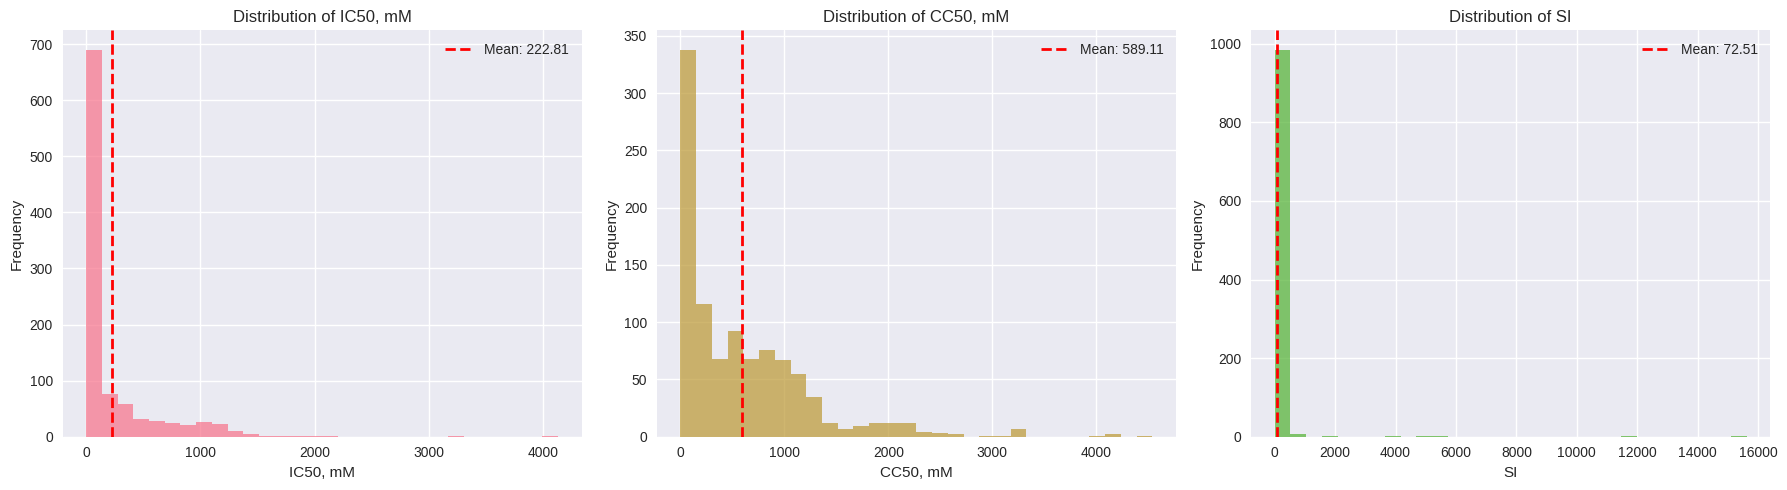

In [5]:
# Distribution plots for target variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, target in enumerate(target_vars):
    axes[i].hist(data[target], bins=30, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'Distribution of {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel('Frequency')
    
    # Add statistics to the plot
    mean_val = data[target].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('../figures/target_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

Correlation matrix for target variables:
          IC50, mM  CC50, mM        SI
IC50, mM  1.000000  0.521346 -0.056604
CC50, mM  0.521346  1.000000 -0.006818
SI       -0.056604 -0.006818  1.000000


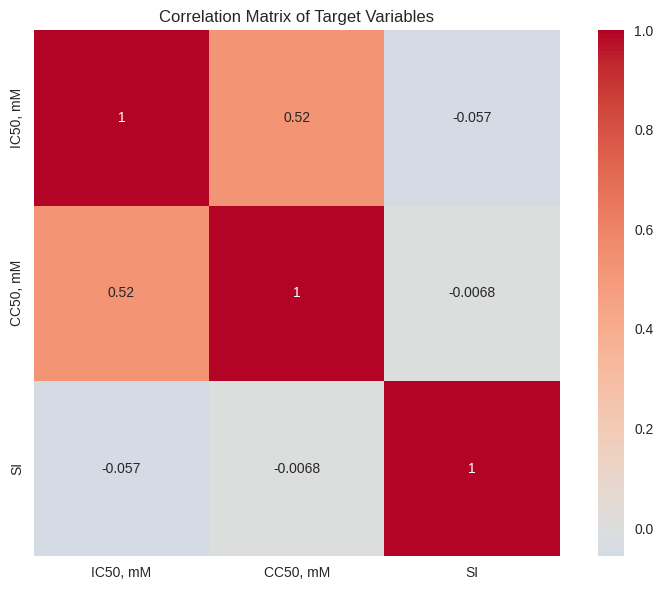

In [6]:
# Correlation analysis between target variables
target_corr = data[target_vars].corr()
print("Correlation matrix for target variables:")
print(target_corr)

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Target Variables')
plt.tight_layout()
plt.savefig('../figures/target_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Create classification targets
data['IC50_above_median'] = (data['IC50, mM'] > data['IC50, mM'].median()).astype(int)
data['CC50_above_median'] = (data['CC50, mM'] > data['CC50, mM'].median()).astype(int)
data['SI_above_median'] = (data['SI'] > data['SI'].median()).astype(int)
data['SI_above_8'] = (data['SI'] > 8).astype(int)

# Class balance for classification targets
class_targets = ['IC50_above_median', 'CC50_above_median', 'SI_above_median', 'SI_above_8']
class_balance = {}
for target in class_targets:
    class_balance[target] = data[target].value_counts()
    
print("Class balance for classification targets:")
for target, counts in class_balance.items():
    print('\n')
    print(counts)
    print(f"Proportion of positive class: {counts[1] / len(data):.2%}")

Class balance for classification targets:


IC50_above_median
0    501
1    500
Name: count, dtype: int64
Proportion of positive class: 49.95%


CC50_above_median
0    502
1    499
Name: count, dtype: int64
Proportion of positive class: 49.85%


SI_above_median
0    501
1    500
Name: count, dtype: int64
Proportion of positive class: 49.95%


SI_above_8
0    644
1    357
Name: count, dtype: int64
Proportion of positive class: 35.66%


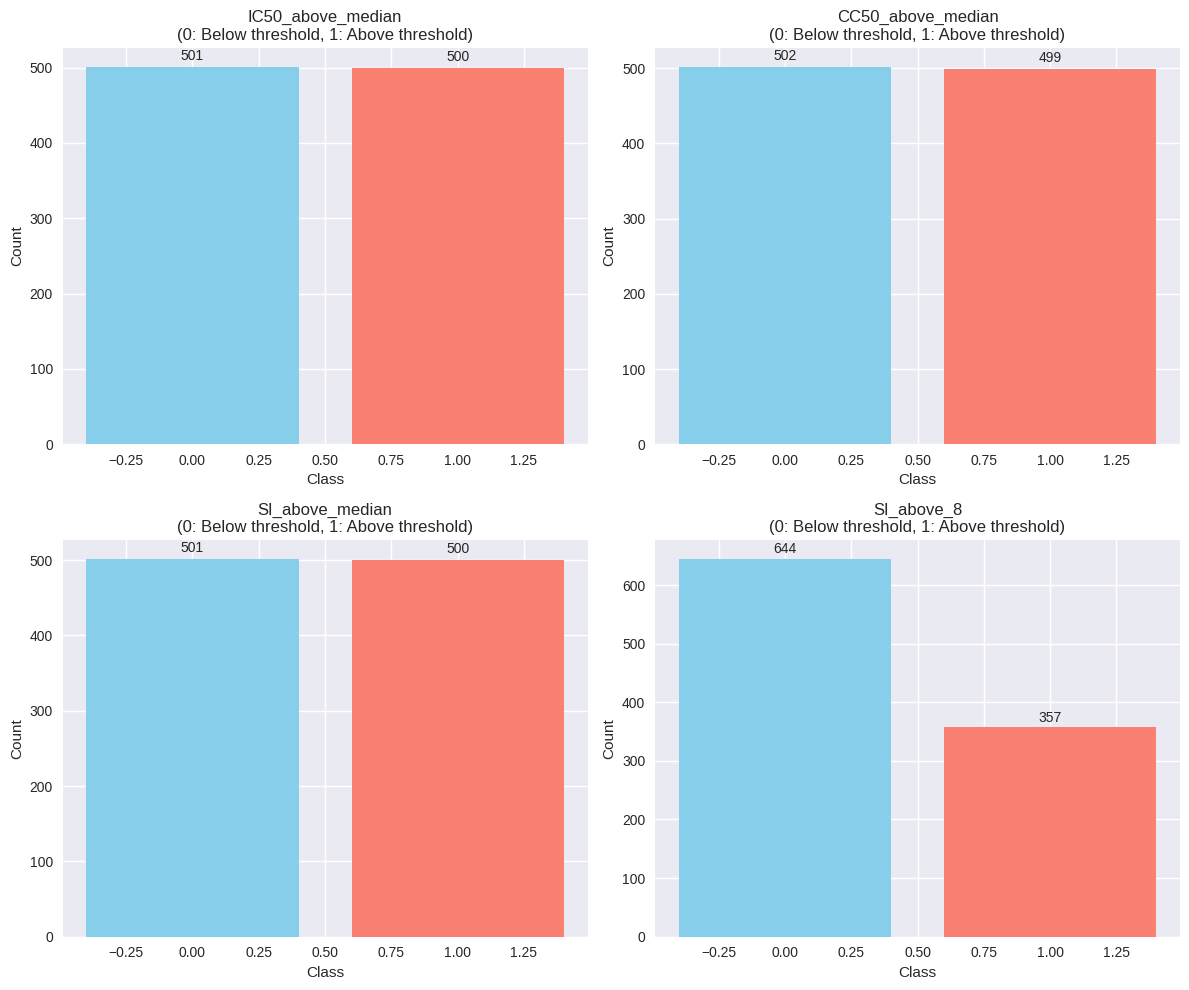

In [8]:
# Visualization of class balance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, target in enumerate(class_targets):
    class_counts = data[target].value_counts()
    axes[i].bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])
    axes[i].set_title(f'{target}\n(0: Below threshold, 1: Above threshold)')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel('Count')
    
    # Add value labels on bars
    for j, v in enumerate(class_counts.values):
        axes[i].text(j, v + 5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../figures/class_balance.png', dpi=300, bbox_inches='tight')
plt.show()